# Información Geográfica y Machine Learning: un ejemplo de modelo de ayuda a la toma de decisiones en la expansión de alojamientos turísticos

En este Jupyter Notebook (versión Colab de Google) se va explicar, paso a paso, la elaboración de un modelo territorial orientado a la toma de decisiones en una operación de expansión de alojamientos turísticos.


## Jupyter Notebooks y Google Colab

Esta herramienta que estamos utilizando se llama **Jupyter Notebook**, en su versión cloud patrocinada y hospedada por Google, llamado **Google Colab** (o Colaboratory). Los Jupyter Notebooks son una herramienta muy arraigada en el ecosistema Python (aunque el modelo ha sido exportado a otros entornos, como JavaScript, por ejemplo, o R). Los objetivos de esta herramienta son básicamente dos:

- establecer un entorno **interactivo** de computación en Python que facilita la exploración de datos y código;
- tiene una orientación eminentemente didáctica, puesto que permite combinar celdas (como esta) de texto enriquecido para articular una explicación con otras de código Python ejecutable.

Esta versión Colab de Jupyter se ejecuta en máquinas en la nube de Google. Su uso es gratuíto y puede escalar, con pago por uso o demanda, a entornos más potentes si se precisa.

Cuando se arranca un Notebook Colab / Jupyter, éste arranca en una máquina de Google y ejecuta su código sobre un **kernel** Python, es decir, un intérprete de Python con el que podemos interaccionar, cargándole datos y definiendo operaciones sobre ellos. Por ejemplo, en la siguiente celda de código Python definimos dos variables en la memoria del kernel, **a** y **b**:

In [ ]:
a = 1
b = 10

Y en la siguiente celda de código realizamos una operación interactiva con ellos:

In [ ]:
a + b

Sin embargo, como el objetivo de la sesión es metodológico y no técnico, evitaremos en la medida de lo posible el código Python encapsulandolo en una librería escrita en un módulo aparte. Dicho módulo está disponible en el repositorio de origen de este Notebook [https://github.com/malkab/turismo_geo_ml/](https://github.com/malkab/turismo_geo_ml/) en la carpeta D: XXX.

Primero, tenemos que cargar el módulo de Python que contiene todo el código del modelo. Este módulo se alojará en la carpeta de la máquina proporcionada por Google **/content/lib**:

In [281]:
# Descargamos el módulo desde el repositorio GitHub
!wget -P /content/lib --no-check-certificate --no-proxy \
'https://raw.githubusercontent.com/malkab/turismo_geo_ml/main/lib/__init__.py' \
'https://raw.githubusercontent.com/malkab/turismo_geo_ml/main/lib/turismoml.py'

/usr/bin/sh: 1: wget: not found


In [282]:
# Configuramos su directorio dentro del kernel Python
import sys
sys.path.append('/content/lib')

# Importamos el módulo para poder usarlo
import turismoml

# Instalamos un paquete que necesitaremos
# D:
# !pip install kmodes seaborn mapboxgl ahpy

# Carga de los datos de encuestas

Cargamos los datos de encuestas y los exploramos un poco, viendo cuántas filas y columnas tiene (209 filas por 9 columnas de datos):

- **edad:** dato continuo
- **acompanyantes:** acompañantes del encuestado (amigos, pareja, unidad familiar)
- **tipo_alojamiento:** tipo de alojamiento (Hotel 5 estrellas, Hotel 4 estrellas, Hotel 3 estrellas, apartamento de uso turístico)
- **sol_playa:** interés en sol y playa, tipo si / no
- **naturaleza_rural:** interés en naturaleza y turismo rural, tipo si / no
- **cultural:** interés en cultura, tipo si / no
- **deporte:** interés en deporte, en este caso exclusivamente golf, tipo si / no
- **gastronomia:** interés en gastronomía, tipo si / no
- **estudios:** estancia por estudios (idiomas), tipo si / no

In [285]:
encuestas = turismoml.cargaEncuestas("../data/000_in/encuestas.csv")

encuestas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   edad              209 non-null    int64 
 1   acompanyantes     209 non-null    object
 2   tipo_alojamiento  209 non-null    object
 3   sol_playa         209 non-null    bool  
 4   naturaleza_rural  209 non-null    bool  
 5   cultural          209 non-null    bool  
 6   deporte           209 non-null    bool  
 7   gastronomia       209 non-null    bool  
 8   estudios          209 non-null    bool  
dtypes: bool(6), int64(1), object(2)
memory usage: 6.2+ KB


Estudiamos la distribución estadística de la edad:

In [287]:
encuestas.describe()

,edad
count,209.000
mean,46.435
std,17.205
min,21.000
25%,29.000
50%,46.000
75%,60.000
max,84.000


Estudiamos las clases únicas de los campos "acompanyantes" y "tipo_alojamiento":

In [288]:
print("Clases en el campo 'acompañantes': ", encuestas["acompanyantes"].unique())
print("Clases en el campo 'alojamiento': ", encuestas["tipo_alojamiento"].unique())

Clases en el campo 'acompañantes':  ['amigos' 'pareja' 'unidad familiar']
Clases en el campo 'alojamiento':  ['hotel 5 estrellas' 'hotel 4 estrellas'
 'apartamento / viviendas uso turístico' 'hotel 3 estrellas' 'otros']


Vemos las primeras líneas:

In [289]:
encuestas.head()

,edad,acompanyantes,tipo_alojamiento,sol_playa,naturaleza_rural,cultural,deporte,gastronomia,estudios
0,69,amigos,hotel 5 estrellas,False,False,True,False,True,False
1,56,pareja,hotel 5 estrellas,False,False,True,False,True,False
2,71,pareja,hotel 5 estrellas,False,False,True,False,False,False
3,66,pareja,hotel 5 estrellas,False,False,True,False,True,False
4,53,unidad familiar,hotel 5 estrellas,False,False,True,False,True,False


Estudiamos el histograma de frecuencias de las edades de los encuestados:

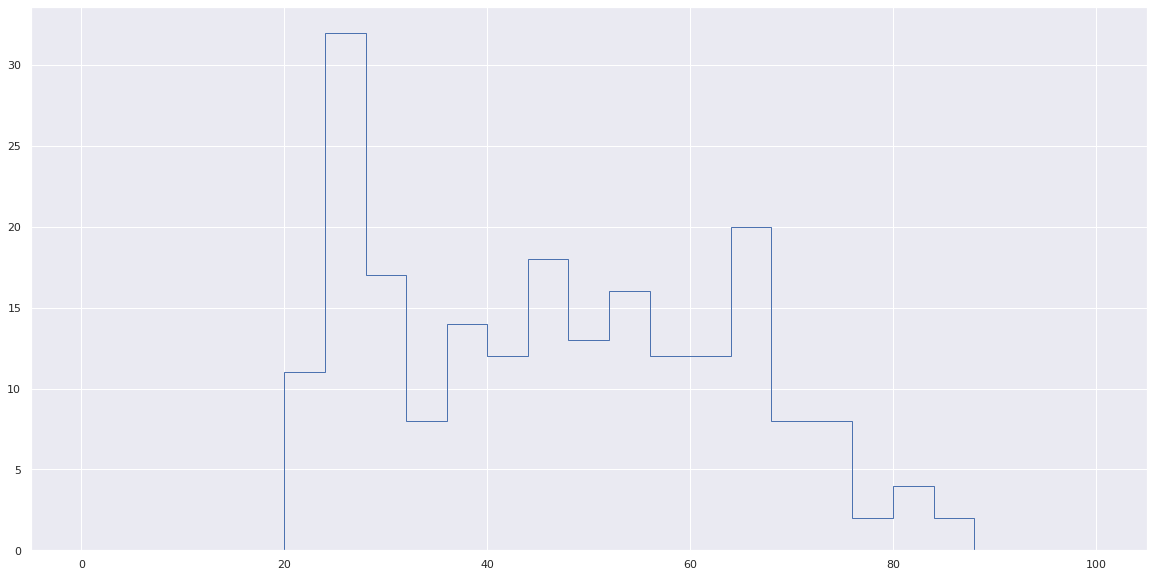

In [294]:
turismoml.histograma(encuestas["edad"], (0, 100), bins=25)

También podemos estudiar la frecuencia de las variables categóricas:

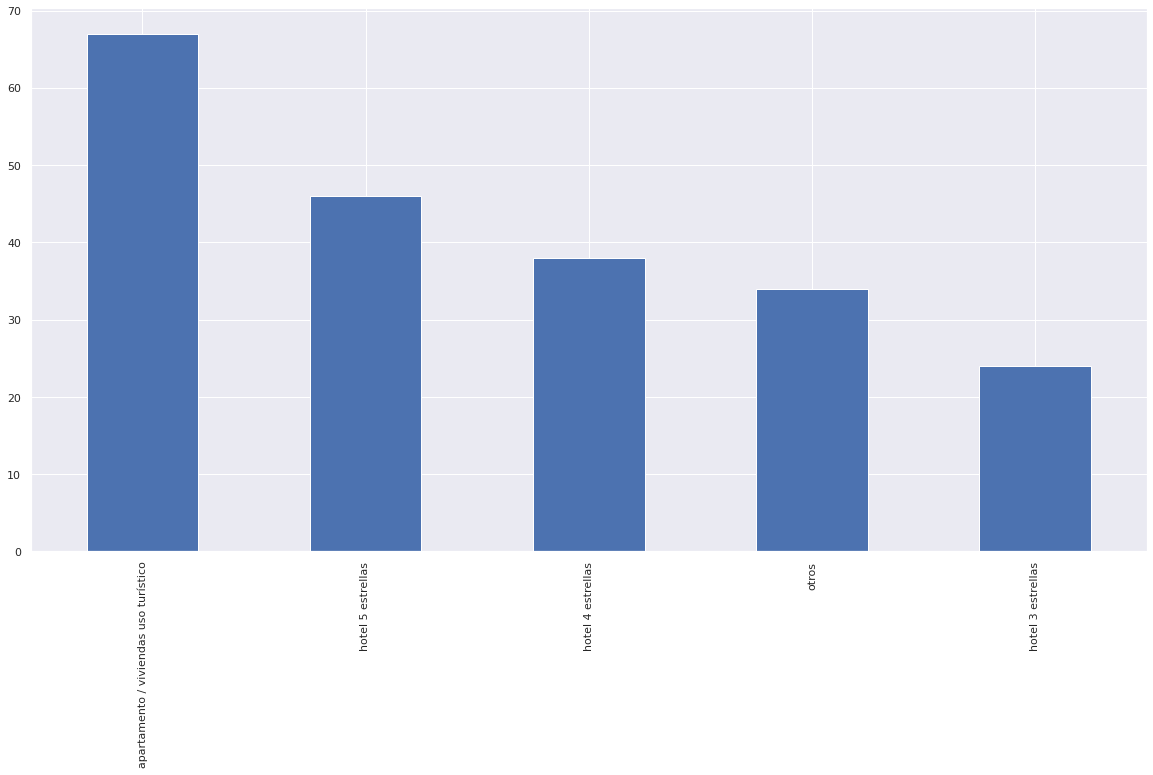

In [295]:
turismoml.histogramaDiscretas(encuestas["tipo_alojamiento"])

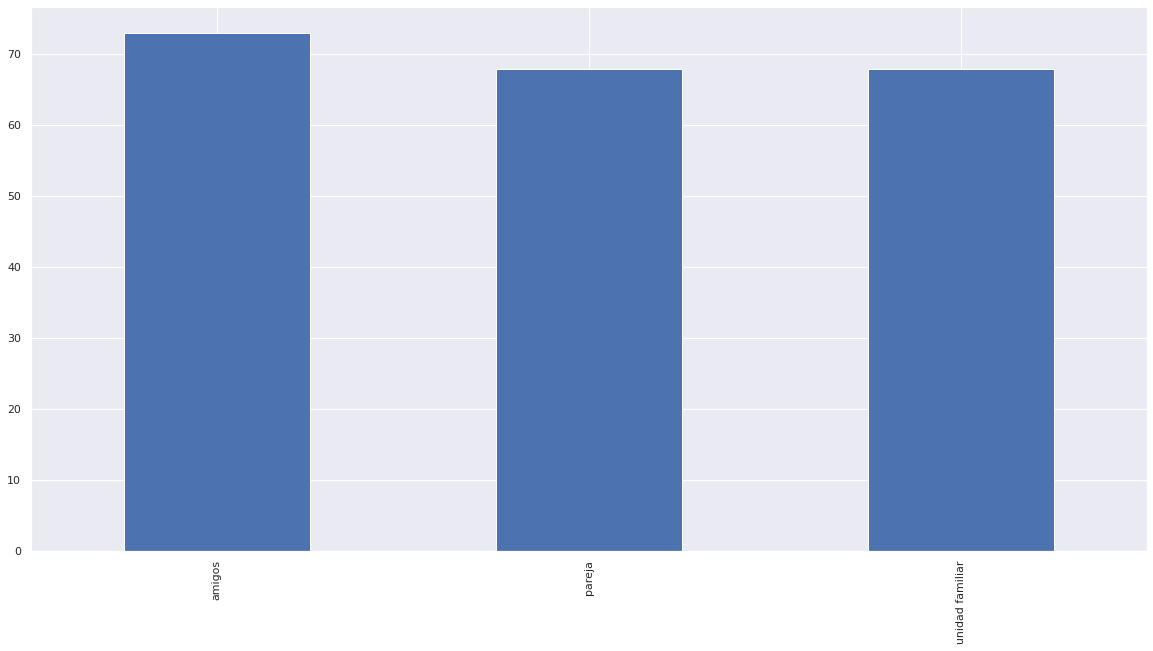

In [296]:
turismoml.histogramaDiscretas(encuestas["acompanyantes"])

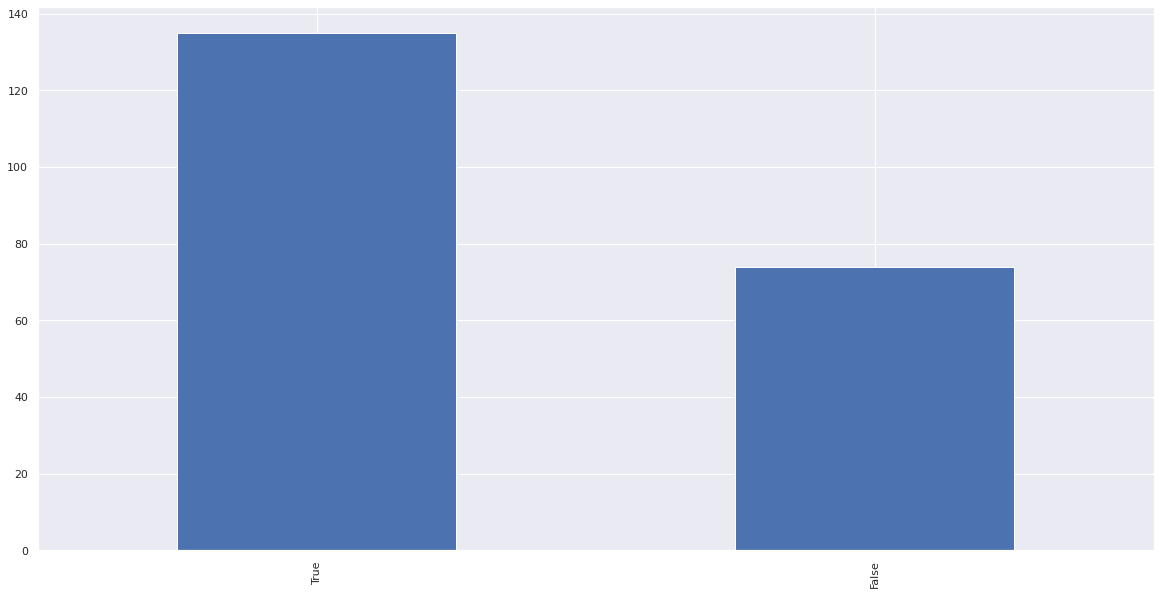

In [298]:
turismoml.histogramaDiscretas(encuestas["cultural"])

# Segmentación de las encuestas

Vamos a utilizar una técnica de clasificación no asistida de los datos de las encuestas. Utilizaremos una variante del conocido clasificador K-Means llamado K-Prototypes, que es capaz de analizar datos mezcla de variables continuas (como la edad) y variables categóricas (como todas las demás). 

El K-Prototypes busca clústeres (grupos de datos similares) en función de sus diferencias o semejanzas en el set de datos categóricos, mientras hace un análisis paralelo K-Means normal para las variables continuas. En esencia, el K-Means funciona en pasos iterativos de refinamiento:

D:
![imagen]

Vamos a ejecutar primero el "Método del codo", un método mediante el cual se estudia la eficiencia de la clusterización para varios números de clusters (en este caso, de 1 al 10). Cuanto menor coste, más cohesionados son los clústers resultantes (es decir, los elementos agrupados en un cluster son más similares, de media, los unos con los otros). Llega un momento en que aumentar los clusters no hace disminuir significativamente el coste, por lo que es un buen indicativo de que ese es el número de clusters significativo que no generaliza demasiado y provoca sobreajuste ("overfitting"):

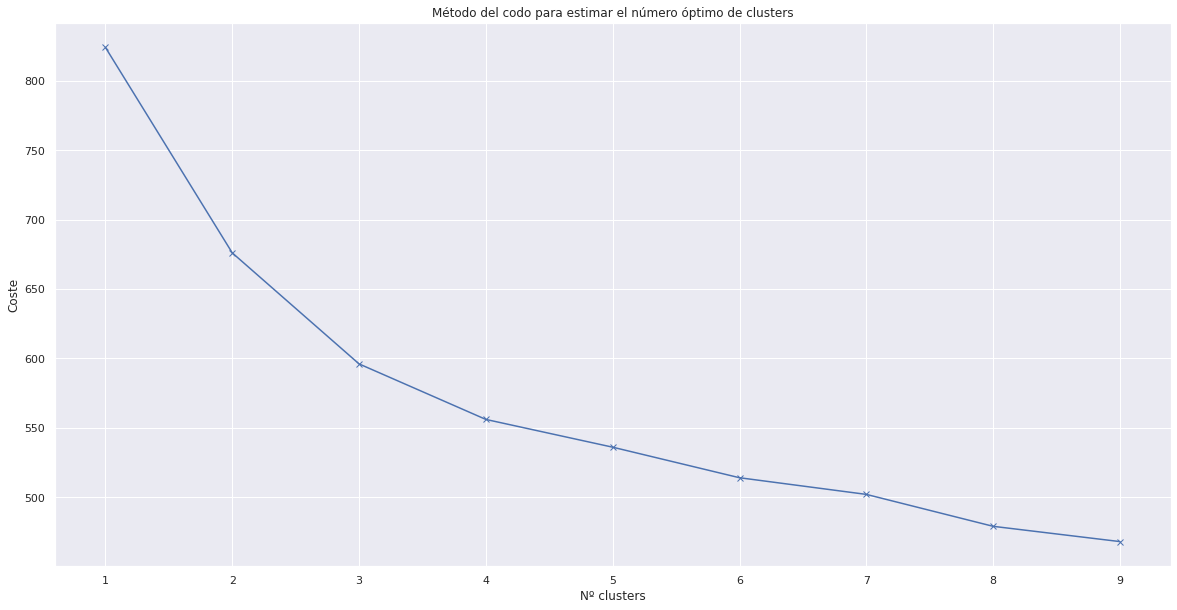

In [300]:
turismoml.analisisCodo(encuestas, (1, 10))

In [304]:
clusters, clustersId, conteo = turismoml.kprototypes(encuestas, 4)

Best run was number 2


Vemos la descripción de los núcleos (kernels) de los clústers, es decir, el dato tipo de cada uno de ellos:

In [307]:
clusters

[{'Edad media': '26.095238095238095',
  'Acompañantes': 'amigos',
  'Tipo alojamiento': 'otros',
  'Sol y playa': 'False',
  'Naturaleza / rural': 'False',
  'Cultural': 'False',
  'Deporte': 'False',
  'Gastronomia': 'True',
  'Estudios': 'True'},
 {'Edad media': '70.52173913043478',
  'Acompañantes': 'pareja',
  'Tipo alojamiento': 'hotel 5 estrellas',
  'Sol y playa': 'False',
  'Naturaleza / rural': 'False',
  'Cultural': 'True',
  'Deporte': 'True',
  'Gastronomia': 'True',
  'Estudios': 'False'},
 {'Edad media': '54.98039215686274',
  'Acompañantes': 'pareja',
  'Tipo alojamiento': 'apartamento / viviendas uso turístico',
  'Sol y playa': 'False',
  'Naturaleza / rural': 'False',
  'Cultural': 'True',
  'Deporte': 'False',
  'Gastronomia': 'True',
  'Estudios': 'False'},
 {'Edad media': '41.08163265306123',
  'Acompañantes': 'unidad familiar',
  'Tipo alojamiento': 'apartamento / viviendas uso turístico',
  'Sol y playa': 'False',
  'Naturaleza / rural': 'False',
  'Cultural': 'T

Vemos cuántas encuestas caen en cada clúster:

In [308]:
conteo

array([63, 46, 51, 49])

In [248]:
# D: quitar, sólo desarrollo
import importlib
importlib.reload(turismoml)

<module 'turismoml' from '/content/lib/turismoml.py'>

# Modelos geográficos gravitacionales para la identificación multicriterio de zonas óptimas de desarrollo de actividades y de atractivo de apoyo a la toma de decisiones

A continuación describimos un sencillo ejemplo de cómo se articulan los modelos geográficos gravitacionales multicriterio para determinar zonas óptimas para el desarrollo de diversas actividades.

Estos modelos geográficos se basan, obviamente, en las relaciones de distancia a los objetos o zonas de interés. Según la Primera Ley de Tobler (uno de los padres del análisis geográfico), "En el espacio geográfico, todo está relacionado con todo, pero las cosas cercanas tienen más relación que las cosas lejanas". Es decir, se comprueba que los fenómenos geográficos cercanos tienen una relación fuerte entre sí, aunque también están relacionados gracias a una función distancia con objetos potencialmente lejanos. Dicho de otra manera, la influencia que tiene un objeto sobre el territorio disminuye con la distancia. Esto es un hecho fundamental en la distribución de servicios e infraestructuras sobre el territorio y, por tanto, fundamental también en el geomarketing o en la elección de zonas potencialmente óptimas para el desarrollo de una actividad.

Este decaimiento de la influencia con la distancia no es uniforme para todas las actividades, sino que se da una distancia umbral a partir de la cual la significación o importancia del fenómeno estudiado decae significativamente. Por ejemplo, el área de influencia de una panaderia es de escasos metros, puesto que no estamos dispuestos a recorrer 3 kilómetros para comprar el pan. Sin embargo, para comprar un coche o un mueble estamos dispuestos a hacernos cientos de kilómetros si la oportunidad es buena.

En los alojamientos turísticos, por supuesto, esta ley también se cumple. El cliente que valora los servicios de un hotel de 5 estrellas como un atractivo turístico en si mismo puede estar más dispuesto, por ejemplo, a hacer más distancia hasta los atractivos turísticos del lugar. El área de influencia de un hotel de 5 estrellas es más amplio, por ejemplo, que el de un apartamento turístico. En el caso del apartamento turístico se valora más la ubicación, por que en el área de influencia de un hotel de 5 estrellas caben cómodamente muchos apartamentos turísticos sin perder necesariamente competitividad.

Por lo tanto, lo primero que haremos es estudiar la ubicación de los factores geográficos que afectan al modelo. Vamos a considerar los siguientes elementos:

- **accesos a la ciudad de alta capacidad:** estaciones de tren, autobús y aeropuerto, categorizadas además por una valoración categórica de su importancia (en este caso, la estación de tren de Santa Justa tiene máxima importancia, después el Aeropuerto de San Pablo y por último la estación de autobuses de Plaza de Armas);

- **ubicaciones de las distintas categorías de alojamientos:** con especial atención, por la segmentación de las encuestas, a los hoteles de 5 estrellas y a los apartamentos turísticos;

- **ubicación de los distintos atractivos turísticos culturales:** con una valoración categórica de su importancia;

- **golf:** ubicación de los campos de golf del área metropolitana;

- **renta:** la distribución de la renta de la unidad familiar en la ciudad, como indicador, digamos, de tipología urbanística;

- **restauración:** la oferta gastronómica.

Se puede acceder a los mapas de estas variables en los siguientes enlaces. Los mapas están hechos con la plataforma de análisis cartográfico CARTO:

- [Renta](https://test-master-iot-usal.carto.com/builder/f93da941-d3fa-4620-b0ad-9d293a7fee54/embed)

- [Accesos](https://test-master-iot-usal.carto.com/builder/7e5a8aaa-1be0-4f37-88e8-cd7dba06d907/embed)

- [Hoteles 5 estrellas](https://test-master-iot-usal.carto.com/builder/6f617004-81e3-4c95-a4ba-f5c9ddbfdd5b/embed)

- [Apartamentos turísticos](https://test-master-iot-usal.carto.com/builder/e4a5805b-7c86-4d80-9c87-669dc7fcef28/embed)

- [Atractivos turísticos](https://test-master-iot-usal.carto.com/builder/8036ee4e-d31a-4ca7-9033-13dc3804e603/embed)

- [Restauración](https://test-master-iot-usal.carto.com/builder/c638c0bb-6c2a-4068-8b65-e40bee97b112/embed)

- [Golf](https://test-master-iot-usal.carto.com/builder/e56d618b-f01f-44b0-bfd5-b4260d0d046b/embed)


## Confección del modelo geográfico

Una vez recabados los datos de ubicación de las distintas variables, hay que estimar ese impacto territorial que tiene cada uno de los elementos considerados. 

Para ello, lo primero que se hace es discretizar el espacio geográfico en unidades regulares. En este caso, se ha utilizado un sistema de rejilla de 250 metros de lado. Es una resolución espacial un tanto basta (en datos geográficos, obviamente, la escala del dato es fundamental que esté acorde a las necesidades del problema) pero a modo de demostración aligera mucho los cálculos:

D:
![imagen]

Una vez determinado este marco espacial analítico, hay que estudiar el impacto territorial de las variables. Existen muchas técnicas para hacerlo, y en este ejemplo se han utilizado tres:

- **estudio de la distancia mínima a los datos:** para cada celda del marco analítico, ¿cuál es la distancia mínima a cualquier ocurrencia al fenómeno?;

D:
![imagen]

- **estudio de kernel:** los estudios de kernel, de los que hay multitud de métodos, dan una idea de la densidad espacial del fenómeno;

- **estudio de distancia media:** para cada unidad analítica se ofrece la distancia media a todos los elementos del fenómeno considerado. Cuanto más alta esta distancia media, más accesible es dicha unidad analítica a todos los elementos considerados. Esta distancia, además, puede ser ponderada, es decir, hay elementos territoriales que ejercen una mayor atracción que otros. Por ejemplo, en la imagen considerada de distancia media a atractivos turísticos, el entorno de la Catedral tiene máximo atractivo, mientras que Itálica, al nordeste del área metropolitana, tiene un atractivo menor. La distancia media se ve afectada por esta valoración subjetiva.

D:
![imagen]

Es importante destacar que estos análisis de decaimiento del interés del fenómeno por la distancia se establece en base a unas distancias umbrales, tal y como se ha comendado anteriormente. Para las variables consideradas, en metros:

- **accesos:**                     5000
- **hoteles 5 estrellas:**         5000
- **hoteles 4 estrellas:**         1000
- **hoteles 3 estrellas:**         750
- **apartamentos turísticos:**     500
- **atractivos turísticos:**       1000
- **golf:**                        5000
- **restauración:**                500

También es importante que todos estos cálculos de decaimiento de la influencia por distancia estén codificados bajo el mismo rango de variable, en este caso entre en el rango [0, 1]. Si no fuera así, las variables tendrían pesos distintos y afectarían al resultado del modelo de partida. Por lo tanto, todos los cálculos de influencia tienen que estar normalizados al mismo rango numérico.

El cálculo de estas influencias se realiza en una **base de datos relacional geográfica PostGIS** con **SQL**. Existe un gran ecosistema de herramientas para hacer estos cálculos, desde los tradicionales **Sistemas de Información Geográfica (SIG)** de escritorio como **QGIS**, **GRASS** o **ArcGIS** hasta lenguajes de programación como **R**, **Python** o **JavaScript / TypeScript**, cada entorno con sus ventajas y desventajas.


## Uso de los cálculos de fricción por distancia para la ubicación de zonas óptimas

Vamos a utilizar los cálculos generados anteriormente para generar dos modelos de idoenidad para la ubicación de posibles nuevos alojamientos turísticos. En base a la segmentación de las encuestas, tenemos dos grupos de usuarios bien diferenciados:

- por un lado, unidades familiares interesadas en el turismo cultural y gastronómico con predilección por el apartamento turístico;

- por otro, parejas interesadas en el turismo cultural, gastronómico y de golf con preferencia por los hoteles de 5 estrellas.

Vamos a valorar los datos que influyen en el modelo:

- modelo 1 (hoteles de 5 estrellas):
    - nivel de renta
    - ubicación de hoteles de 5 estrellas existentes
    - distancia a los accesos a la ciudad
    - accesibilidad a los atractivos turísticos culturales
    - accesibilidad a la oferta de restauración
    - accesibilidad a los campos de golf
    
- modelo 2 (apartamentos turísticos):
    - nivel de renta
    - ubicación de apartamentos turísticos existentes
    - distancia a los accesos a la ciudad
    - accesibilidad a los atractivos turísticos culturales
    - accesibilidad a la oferta de restauración
    
Los modelos espaciales de este tipo son polinómicos, es decir, se calculan a partir de la suma de la distribución espacial de los cálculos de fricción por distancia discutidos anteriormente, ponderados por un peso que relativiza la importacia de cada uno de las variables consideradas:

```shell
I = p0 * variable0 + p1 * variable1 + ... + pn * variablen
```

Estos pesos pueden ser positivos, en el caso de que la cercanía sea un factor beneficioso ("estar cerca de los atractivos turísticos") o negativos, en el caso de que sean contraproducente ("cercanía a la competencia ya implantada").

La determinación de estos pesos ha sido un problema recurrente en Ciencias Sociales, ya que son arbitrarios. El criterio de cada experto en la materia puede variar. Por supuesto, varia de lugar en lugar, ya que una variable de escasa importancia en un destino puede ser capital en otro. Por lo tanto, debe haber una formulación estadística que consensue la opinión de los expertos temáticos.

Uno de los métodos más utilizados es el conocido como **Analytic Hierarchy Process**, también conocido como método **Saaty** por su formulador **Thomas Saaty** (1970). El método Saaty se basa en pasar una encuesta a cada experto temático en la que éste realiza una valoración subjetiva del peso de cada una de ellas con respecto a todas las demás. Por ejemplo, en el primero de nuestros casos, el experto debería contestar a las siguientes valoraciones:

- peso de la renta frente a la ubicación de la competencia;
- peso de la renta frente a la ubicación de los atractivos turísticos;
- peso de la renta frente a la ubicación de los accesos;
- peso de la renta frente a la ubicación de los puntos de restauración;
- peso de la renta frente a la ubicación de los campos de golf;
- peso de la ubicación de la competencia frente a la ubicación de los atractivos turísticos;
- peso de la ubicación de la competencia frente a la ubicación de los accesos;
- peso de la ubicación de la competencia frente a la ubicación de los puntos de restauración;
- peso de la ubicación de la competencia frente a la ubicación de los campos de golf;
- peso de la ubicación de los atractivos turísticos frente a la ubicación de los accesos;
- peso de la ubicación de los atractivos turísticos frente a la ubicación de los puntos de restauración;
- peso de la ubicación de los atractivos turísticos frente a la ubicación de los campos de golf;
- peso de la ubicación de los accesos frente a la ubicación de los puntos de restauración;
- peso de la ubicación de los accesos frente a la ubicación de los campos de golf;
- peso de la ubicación de los puntos de restauración frente a la ubicación de los campos de golf.

a lo que el experto responde con una escala 1,2,3,4,5,7,9 que mide la importancia relativa de la primera frente a la segunda. Por ejemplo, si consideramos que la ubicación de los atractivos turísticos es infinitamente más importante que la ubicación de los accesos a la ciudad, esta relación estaría tasada en un 9. Sin embargo, si consideramos que la ubicación de los accesos carece de total importancia comparado con el acceso a los campos de golf, estaría tasada con un 1/9. Una tasación de 1 pone en pié de igualdad ambas variables consideradas.

Una vez cada experto ha remitido su valoración, se le hace un análisis estadístico por modas para ver cuál es la opinión preponderante para cada relación entre variables, considerándose ese el consenso experto. Estas valoraciones son sometidas al tratamiento del algoritmo de Saaty, que devolverá el conjunto de pesos de cada variable en el polinomio (los pesos deben sumar 1). Con estos pesos, finalmente, se calibra el modelo:

In [309]:
import ahpy

# Modelo 1
# Variables: renta, hotel5_kernel, atractivos_wavg, accesos_wavg, restauracion_avg, golf_avg

comparisons_1 = {
    ('renta', 'hotel5_kernel'): 3,
    ('renta', 'atractivos_wavg'): 9,
    ('renta', 'accesos_wavg'): 9,
    ('renta', 'restauracion_avg'): 9,
    ('renta', 'golf_avg'): 2,
    ('hotel5_kernel', 'atractivos_wavg'): 9, 
    ('hotel5_kernel', 'accesos_wavg'): 9, 
    ('hotel5_kernel', 'restauracion_avg'): 9, 
    ('hotel5_kernel', 'golf_avg'): 9, 
    ('atractivos_wavg', 'accesos_wavg'): 9,
    ('atractivos_wavg', 'restauracion_avg'): 1,
    ('atractivos_wavg', 'golf_avg'): 1/9,
    ('accesos_wavg', 'restauracion'): 1/9,
    ('accesos_wavg', 'golf_avg'): 1/9,
    ('restauracion_avg', 'golf_avg'): 1/9
}

# Modelo 2
# Variables: renta, apartamentos_kernel, atractivos_wavg, accesos_wavg, restauracion_avg

comparisons_2 = {
    ('renta', 'apartamentos_kernel'): 1,
    ('renta', 'atractivos_wavg'): 2,
    ('renta', 'accesos_wavg'): 9,
    ('renta', 'restauracion_avg'): 2,
    ('apartamentos_kernel', 'atractivos_wavg'): 6, 
    ('apartamentos_kernel', 'accesos_wavg'): 9, 
    ('apartamentos_kernel', 'restauracion_avg'): 6, 
    ('atractivos_wavg', 'accesos_wavg'): 9,
    ('atractivos_wavg', 'restauracion_avg'): 1,
    ('accesos_wavg', 'restauracion_avg'): 1/9
}


Lo pasamos por Saaty:

In [310]:
ahpy_1 = ahpy.Compare(name='modelo_1', comparisons=comparisons_1, precision=3, 
                    random_index='saaty')

ahpy_2 = ahpy.Compare(name='modelo_2', comparisons=comparisons_2, precision=3, 
                    random_index='saaty')

Y comprobamos resultados:

In [311]:
ahpy_1.target_weights

{'hotel5_kernel': 0.333,
 'renta': 0.319,
 'golf_avg': 0.145,
 'restauracion': 0.121,
 'atractivos_wavg': 0.041,
 'restauracion_avg': 0.025,
 'accesos_wavg': 0.017}

In [312]:
ahpy_2.target_weights

{'apartamentos_kernel': 0.455,
 'renta': 0.268,
 'atractivos_wavg': 0.126,
 'restauracion_avg': 0.126,
 'accesos_wavg': 0.025}

Finalmente, estos pesos se vuelven a utilizar con **SQL** sobre la base de datos que calcula, para cada unidad de superficie discreta, el resultado final del modelo, que se pueden consultar en:

- [Resultado modelo 1 (hoteles 5 estrellas)](https://test-master-iot-usal.carto.com/builder/f5af0b0e-5dba-4e41-8c4b-694edac80397/embed)

- [Resultado modelo 2 (apartamentos turísticos)](https://test-master-iot-usal.carto.com/builder/21f994ef-ee6e-4c7b-a11e-ef46d3f5d310/embed)